In [40]:
from mpi4py import MPI
import numpy as np
from petsc4py import PETSc
from slepc4py import SLEPc
from dolfinx.io import XDMFFile
from dolfinx import mesh, fem
from dolfinx.fem import Constant,Function
import ufl
from ufl import TrialFunction, TestFunction, sym, grad, tr, Identity, inner, dx
from ufl import VectorElement


In [41]:
import dolfinx
print(dolfinx.__version__)

0.5.2


In [42]:
# -------------------------
# Geometry (3D block)
# -------------------------
Lx, Ly, Lz = 1.0, 0.1, 0.1
nx, ny, nz = 20, 10,10

domain = mesh.create_box(
    MPI.COMM_WORLD,
    np.array([[0.0, 0.0, 0.0],
             [Lx,  Ly,  Lz]]),
    [nx, ny, nz],
    cell_type=mesh.CellType.tetrahedron
)


In [43]:
# -------------------------
# Function space (3D displacement)
# -------------------------
Ve = VectorElement("Lagrange", domain.ufl_cell(), 1)
V = fem.FunctionSpace(domain, Ve)

u = TrialFunction(V)
v = TestFunction(V)


In [44]:
# -------------------------
# Material (3D linear elasticity)
# -------------------------
E = 210e9
nu = 0.3
rho = 7850.0

mu = Constant(domain, E/2./(1+nu))
lambda_ = Constant(domain, E*nu/(1+nu)/(1-2*nu))

# Convenience functions
def eps(u):
    return ufl.sym(ufl.grad(u))
def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(3) + 2*mu*eps(u)


In [45]:
# Stiffness
a = inner(sigma(u), eps(v)) * dx
a_form = fem.form(a)

# Mass
m = rho * inner(u, v) * dx
m_form = fem.form(m)


In [46]:
# -------------------------
# Clamp boundary: x = 0 face
# -------------------------
def clamp_region(x):
    return (
        np.isclose(x[0], 0.5, atol=0.01) &  # 중앙 x=0.5 ± 1cm
        np.isclose(x[2], 0, atol=0.01)  # 바닥
    )

dofs_clamp = fem.locate_dofs_geometrical(V, clamp_region)

zero = np.array([0.0, 0.0, 0.0], dtype=PETSc.ScalarType)
bc = fem.dirichletbc(zero, dofs_clamp, V)
bcs = [bc]


In [47]:
# -------------------------
# Assemble matrices
# -------------------------
K = fem.petsc.assemble_matrix(a_form, bcs=bcs, diagonal=1/62831)
K.assemble()

M = fem.petsc.assemble_matrix(m_form, diagonal=62831)
M.assemble()


In [48]:
# -------------------------
# Lumped mass block (rectangular volume)
# -------------------------
xm0, xm1 = 0.05, 0.1
ym0, ym1 = 0.01, 0.05
zm0, zm1 = 0, 0.01

m_add = 10.0  # kg (총 추가 질량)


In [49]:
def in_mass_block(x):
    return ((x[0] >= xm0) & (x[0] <= xm1) &
            (x[1] >= ym0) & (x[1] <= ym1) &
            (x[2] >= zm0) & (x[2] <= zm1))


In [50]:
dofs_mass = fem.locate_dofs_geometrical(V, in_mass_block)

if len(dofs_mass) == 0:
    raise RuntimeError("Mass block DOFs not found")


In [51]:
ndofs = len(dofs_mass)
m_per_dof = m_add / ndofs

for dof in dofs_mass:
    M.setValue(dof, dof, m_per_dof, addv=True)

M.assemble()


In [52]:
# dofs_clamp = np.array(dofs_clamp, dtype=np.int32)

# # K: 강성 유지 → diag = 1
# K.zeroRowsColumns(dofs_clamp, diag=1.0)

# # M: 질량 제거 → diag = 0
# M.zeroRowsColumns(dofs_clamp, diag=0.0)

# K.assemble()
# M.assemble()



In [53]:
print("Zero rows in K:",
      np.sum(np.isclose(K.getDiagonal().getArray(), 0.0)))
print("Zero rows in M:",
      np.sum(np.isclose(M.getDiagonal().getArray(), 0.0)))


Zero rows in K: 0
Zero rows in M: 0


In [54]:
print("ndofs =", V.dofmap.index_map.size_global * V.dofmap.index_map_bs)

Kd = K.getDiagonal().getArray()
Md = M.getDiagonal().getArray()

print("min/max diag(K):", float(np.min(Kd)), float(np.max(Kd)))
print("min/max diag(M):", float(np.min(Md)), float(np.max(Md)))
print("num zero diag(M):", int(np.sum(np.isclose(Md, 0.0))))


ndofs = 7623
min/max diag(K): 1.5915710397733602e-05 36669230769.23083
min/max diag(M): 0.001308333333333334 2.5157
num zero diag(M): 0


In [55]:
print("clamp dofs:", len(dofs_clamp))
print("ratio:", len(dofs_clamp) / (V.dofmap.index_map.size_global * V.dofmap.index_map_bs))


clamp dofs: 22
ratio: 0.002886002886002886


In [56]:
# Create and configure eigenvalue solver
N_eig = 90
eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
eigensolver.setDimensions(N_eig)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
st = SLEPc.ST().create(MPI.COMM_WORLD)
st.setType(SLEPc.ST.Type.SINVERT)
st.setShift(50)
st.setFromOptions()
eigensolver.setST(st)
eigensolver.setOperators(K, M)
eigensolver.setFromOptions()

# Compute eigenvalue-eigenvector pairs
eigensolver.solve()
evs = eigensolver.getConverged()
vr, vi = K.getVecs()
u_output = Function(V)
u_output.name = "Eigenvector"
print( "Number of converged eigenpairs %d" % evs )
if evs > 0:
    with XDMFFile(MPI.COMM_WORLD, "eigenvectors.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain)
        for i in range (min(N_eig, evs)):
            l = eigensolver.getEigenpair(i, vr, vi)
            freq = np.sqrt(l.real)/2/np.pi
            print(f"Mode {i}: {freq} Hz")
            u_output.x.array[:] = vr
            xdmf.write_function(u_output, i)

Number of converged eigenpairs 116
Mode 0: 0.00444278644620804 Hz
Mode 1: 0.004442786446329574 Hz
Mode 2: 0.004442786446370085 Hz
Mode 3: 0.004504617730278845 Hz
Mode 4: 0.004504617730358755 Hz
Mode 5: 0.00450461773039871 Hz
Mode 6: 0.004607695987305673 Hz
Mode 7: 0.00460769598750098 Hz
Mode 8: 0.004607695987559572 Hz
Mode 9: 0.004751380775563902 Hz
Mode 10: 0.0047513807756207225 Hz
Mode 11: 0.004751380775696482 Hz
Mode 12: 0.004933182509435755 Hz
Mode 13: 0.004933182509526965 Hz
Mode 14: 0.004933182509618175 Hz
Mode 15: 0.005146599445485534 Hz
Mode 16: 0.00514659944553799 Hz
Mode 17: 0.005146599445642904 Hz
Mode 18: 0.00537754545256739 Hz
Mode 19: 0.005377545452584125 Hz
Mode 20: 0.005377545452718001 Hz
Mode 21: 0.005599292720193984 Hz
Mode 22: 0.005599292720193984 Hz
Mode 23: 0.0055992927202261275 Hz
Mode 24: 0.005768501391510905 Hz
Mode 25: 0.00576850139165131 Hz
Mode 26: 0.00576850139165131 Hz
Mode 27: 0.006783164379643528 Hz
Mode 28: 0.006783164379696595 Hz
Mode 29: 0.006783164379

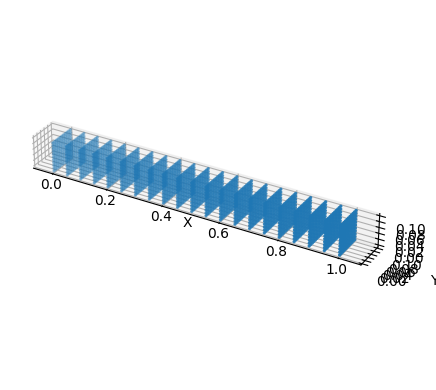

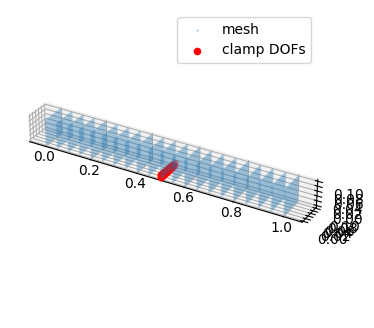

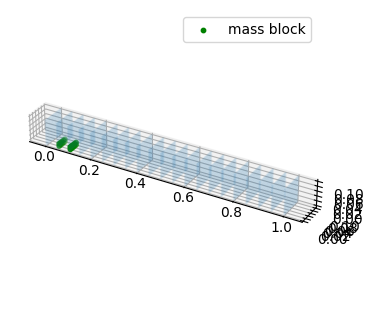

In [57]:
import numpy as np

# 메시의 모든 좌표 (노드 좌표)
coords = domain.geometry.x
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = coords[:, 0]
y = coords[:, 1]
z = coords[:, 2]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z, s=2)   # s = 점 크기
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.set_box_aspect([Lx,Ly, Lz])  # 비율 유지
plt.tight_layout()
plt.show()
# DOF 좌표 얻기
dof_coords = V.tabulate_dof_coordinates().reshape((-1, 3))

clamp_pts = dof_coords[dofs_clamp]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")

# 전체 메시
ax.scatter(x, y, z, s=1, alpha=0.2, label="mesh")

# 클램프 위치
ax.scatter(
    clamp_pts[:, 0],
    clamp_pts[:, 1],
    clamp_pts[:, 2],
    s=20,
    c="r",
    label="clamp DOFs"
)

ax.legend()

ax.set_box_aspect([Lx,Ly, Lz])  # 비율 유지
plt.show()
# 질량 블록 판별
mask = (
    (coords[:,0] >= xm0) & (coords[:,0] <= xm1) &
    (coords[:,1] >= ym0) & (coords[:,1] <= ym1) &
    (coords[:,2] >= zm0) & (coords[:,2] <= zm1)
)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(x, y, z, s=1, alpha=0.1)
ax.scatter(x[mask], y[mask], z[mask], s=10, c="g", label="mass block")

ax.legend()

ax.set_box_aspect([Lx,Ly, Lz])  # 비율 유지
plt.show()


force dof: 1147
resp dof : 547
Mode 66: 122.28 Hz
Mode 67: 266.84 Hz
Mode 68: 363.13 Hz
Mode 69: 374.35 Hz
Mode 70: 1412.59 Hz
Mode 71: 1503.38 Hz
Mode 72: 1700.69 Hz
Mode 73: 1858.58 Hz
Mode 74: 1901.69 Hz
Mode 75: 1976.42 Hz
Mode 76: 2229.05 Hz
Mode 77: 2557.77 Hz
Mode 78: 3765.10 Hz
Mode 79: 4328.21 Hz
Mode 80: 4418.23 Hz
Mode 81: 4598.71 Hz
Mode 82: 5110.38 Hz
Mode 83: 5673.70 Hz
Mode 84: 6445.81 Hz
Mode 85: 6849.50 Hz
Mode 86: 7192.35 Hz
Mode 87: 7503.49 Hz
Mode 88: 7844.60 Hz
Mode 89: 8052.90 Hz
Mode 90: 8600.01 Hz
Mode 91: 9153.66 Hz
Mode 92: 9464.76 Hz
Mode 93: 10028.80 Hz
Mode 94: 10280.99 Hz
Mode 95: 11187.45 Hz
Mode 96: 11427.54 Hz
Mode 97: 11538.66 Hz
Mode 98: 11887.27 Hz
Mode 99: 12900.35 Hz
Mode 100: 13209.35 Hz
Mode 101: 13500.63 Hz
Mode 102: 13690.37 Hz
Mode 103: 14261.37 Hz
Mode 104: 15064.30 Hz
Mode 105: 15211.31 Hz
Mode 106: 16105.12 Hz
Mode 107: 16386.69 Hz
Mode 108: 16544.92 Hz
Mode 109: 17058.01 Hz
Mode 110: 17246.54 Hz
Mode 111: 17294.92 Hz
Mode 112: 17628.30 Hz


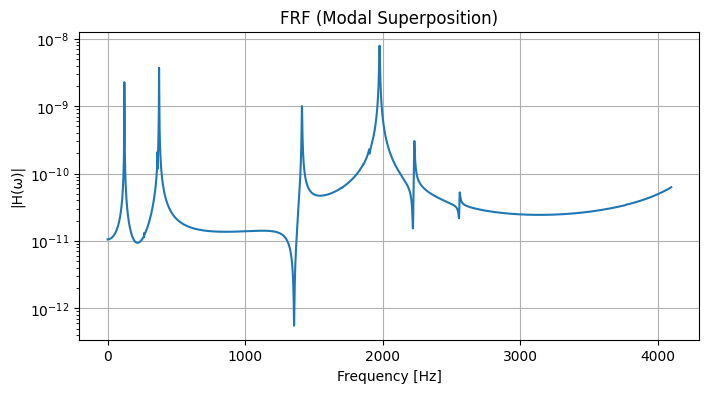

In [58]:

x_force = np.array([0.5, 0.05, 0.05])   # 하중 위치
x_resp  = np.array([1, 0.05, 0.1])   # 응답 위치


coords = V.tabulate_dof_coordinates().reshape((-1, 3))

def find_nearest_dof(point):
    return np.argmin(np.linalg.norm(coords - point, axis=1))

dof_f = find_nearest_dof(x_force)
dof_r = find_nearest_dof(x_resp)

print("force dof:", dof_f)
print("resp dof :", dof_r)

Phi_f = []
Phi_r = []
modes = []     # ← 이게 modes
freqs = []     # 고유진동수도 같이 저장

for i in range(evs):
    l = eigensolver.getEigenpair(i, vr, vi)

    # 고유치 → 주파수
    if l.real <= 0:
        continue

    freq = np.sqrt(l.real) / (2*np.pi)

    # 저주파(강체모드) 컷
    if freq < 5.0:
        continue

    # PETSc Vec → dolfinx Function
    mode = Function(V)
    mode.x.array[:] = vr.array[:]   # ⭐ 핵심
    mode.name = f"mode_{i}"

    modes.append(mode)
    freqs.append(freq)

    print(f"Mode {i}: {freq:.2f} Hz")

omega_r = 2*np.pi*np.array(freqs)   # rad/s
for mode in modes:
    u = mode.x.array.reshape((-1, 3))
    Phi_f.append(u[dof_f, 2])   # 예: z방향
    Phi_r.append(u[dof_r, 2])

Phi_f = np.array(Phi_f)
Phi_r = np.array(Phi_r)

fmin, fmax = 0.0, 4096.0
npts = 4096
freq = np.linspace(fmin, fmax, npts)
omega = 2*np.pi*freq

zeta = 0.001   # 1% modal damping

H = np.zeros_like(omega, dtype=complex)

for r in range(len(omega_r)):
    num = Phi_r[r] * Phi_f[r]
    den = (omega_r[r]**2 - omega**2
           + 2j*zeta*omega_r[r]*omega)
    H += num / den


import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.semilogy(freq, np.abs(H))
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(ω)|")
plt.title("FRF (Modal Superposition)")
plt.grid(True)
plt.show()


Number of converged eigenpairs 119
Mode 0: 0.004442786446187784 Hz
Mode 1: 0.004442786446268807 Hz
Mode 2: 0.004442786446309318 Hz
Mode 3: 0.004504617730178957 Hz
Mode 4: 0.004504617730338778 Hz
Mode 5: 0.004504617730358755 Hz
Mode 6: 0.004607695987344735 Hz
Mode 7: 0.004607695987422857 Hz
Mode 8: 0.004607695987461918 Hz
Mode 9: 0.004751380775431322 Hz
Mode 10: 0.004751380775526022 Hz
Mode 11: 0.004751380775563902 Hz
Mode 12: 0.004933182509453998 Hz
Mode 13: 0.004933182509526965 Hz
Mode 14: 0.004933182509526965 Hz
Mode 15: 0.005146599445450562 Hz
Mode 16: 0.005146599445572961 Hz
Mode 17: 0.005146599445642904 Hz
Mode 18: 0.005377545452500451 Hz
Mode 19: 0.005377545452500451 Hz
Mode 20: 0.005377545452684533 Hz
Mode 21: 0.00559929272008148 Hz
Mode 22: 0.005599292720129696 Hz
Mode 23: 0.005599292720210055 Hz
Mode 24: 0.005768501391339299 Hz
Mode 25: 0.005768501391495305 Hz
Mode 26: 0.005768501391510905 Hz
Mode 27: 0.006783164379577194 Hz
Mode 28: 0.006783164379643528 Hz
Mode 29: 0.00678316

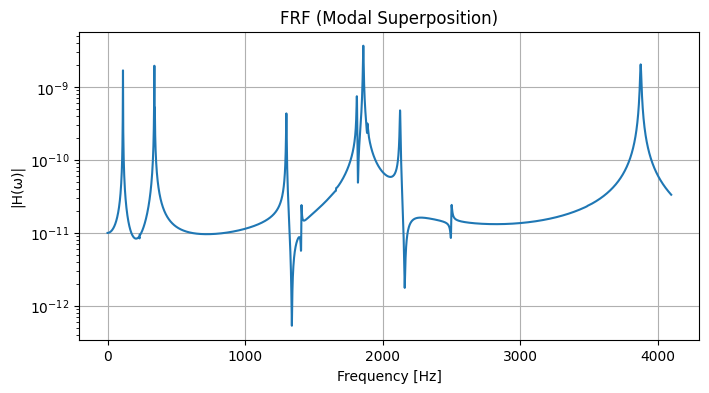

In [59]:
# -------------------------
# Geometry (3D block)
# -------------------------
Lx, Ly, Lz = 1.0, 0.1, 0.1
nx, ny, nz = 20, 10,10

domain = mesh.create_box(
    MPI.COMM_WORLD,
    np.array([[0.0, 0.0, 0.0],
             [Lx,  Ly,  Lz]]),
    [nx, ny, nz],
    cell_type=mesh.CellType.tetrahedron
)
# -------------------------
# Function space (3D displacement)
# -------------------------
Ve = VectorElement("Lagrange", domain.ufl_cell(), 1)
V = fem.FunctionSpace(domain, Ve)

u = TrialFunction(V)
v = TestFunction(V)

xm0, xm1 = 0.5, 0.55
ym0, ym1 = 0.01, 0.05
zm0, zm1 = 0, 0.01

m_add = 20.0  # kg (총 추가 질량)
dofs_mass = fem.locate_dofs_geometrical(V, in_mass_block)

if len(dofs_mass) == 0:
    raise RuntimeError("Mass block DOFs not found")

ndofs = len(dofs_mass)
m_per_dof = m_add / ndofs

for dof in dofs_mass:
    M.setValue(dof, dof, m_per_dof, addv=True)

M.assemble()

# Create and configure eigenvalue solver
N_eig = 90
eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
eigensolver.setDimensions(N_eig)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
st = SLEPc.ST().create(MPI.COMM_WORLD)
st.setType(SLEPc.ST.Type.SINVERT)
st.setShift(50)
st.setFromOptions()
eigensolver.setST(st)
eigensolver.setOperators(K, M)
eigensolver.setFromOptions()

# Compute eigenvalue-eigenvector pairs
eigensolver.solve()
evs = eigensolver.getConverged()
vr, vi = K.getVecs()
u_output = Function(V)
u_output.name = "Eigenvector"
print( "Number of converged eigenpairs %d" % evs )
if evs > 0:
    with XDMFFile(MPI.COMM_WORLD, "eigenvectors.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain)
        for i in range (min(N_eig, evs)):
            l = eigensolver.getEigenpair(i, vr, vi)
            freq = np.sqrt(l.real)/2/np.pi
            print(f"Mode {i}: {freq} Hz")
            u_output.x.array[:] = vr
            xdmf.write_function(u_output, i)


x_force = np.array([0.5, 0.05, 0.05])   # 하중 위치
x_resp  = np.array([1, 0.05, 0.1])   # 응답 위치


coords = V.tabulate_dof_coordinates().reshape((-1, 3))

def find_nearest_dof(point):
    return np.argmin(np.linalg.norm(coords - point, axis=1))

dof_f = find_nearest_dof(x_force)
dof_r = find_nearest_dof(x_resp)

print("force dof:", dof_f)
print("resp dof :", dof_r)

Phi_f = []
Phi_r = []
modes = []     # ← 이게 modes
freqs = []     # 고유진동수도 같이 저장

for i in range(evs):
    l = eigensolver.getEigenpair(i, vr, vi)

    # 고유치 → 주파수
    if l.real <= 0:
        continue

    freq = np.sqrt(l.real) / (2*np.pi)

    # 저주파(강체모드) 컷
    if freq < 5.0:
        continue

    # PETSc Vec → dolfinx Function
    mode = Function(V)
    mode.x.array[:] = vr.array[:]   # ⭐ 핵심
    mode.name = f"mode_{i}"

    modes.append(mode)
    freqs.append(freq)

    print(f"Mode {i}: {freq:.2f} Hz")

omega_r = 2*np.pi*np.array(freqs)   # rad/s
for mode in modes:
    u = mode.x.array.reshape((-1, 3))
    Phi_f.append(u[dof_f, 2])   # 예: z방향
    Phi_r.append(u[dof_r, 2])

Phi_f = np.array(Phi_f)
Phi_r = np.array(Phi_r)

fmin, fmax = 0.0, 4096.0
npts = 4096
freq = np.linspace(fmin, fmax, npts)
omega = 2*np.pi*freq

zeta = 0.001   # 1% modal damping

H = np.zeros_like(omega, dtype=complex)

for r in range(len(omega_r)):
    num = Phi_r[r] * Phi_f[r]
    den = (omega_r[r]**2 - omega**2
           + 2j*zeta*omega_r[r]*omega)
    H += num / den


import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.semilogy(freq, np.abs(H))
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(ω)|")
plt.title("FRF (Modal Superposition)")
plt.grid(True)
plt.show()


In [60]:
import numpy as np
from petsc4py import PETSc
from dolfinx import fem
import ufl

freq = 120.0
omega = 2*np.pi*freq
a_base = 1.0       # m/s^2
zeta = 0.01

ndofs = M.getSize()[0]
bs = V.dofmap.index_map_bs

# ---- 베이스 영향 벡터 b (z방향) ----
b = PETSc.Vec().createMPI(ndofs, comm=M.comm)
b.set(0.0)

clamp_set = set(map(int, dofs_clamp))
r0, r1 = b.getOwnershipRange()
for dof in range(r0, r1):
    if (dof % bs) == 2 and (dof not in clamp_set):
        b.setValue(dof, 1.0)

b.assemblyBegin(); b.assemblyEnd()

Mb = M.createVecRight()
M.mult(b, Mb)

# ---- 모달 중첩 ----
u_resp = np.zeros(ndofs, dtype=np.complex128)

for r, mode in enumerate(modes):
    phi = PETSc.Vec().createWithArray(mode.x.array, comm=M.comm)
    Fr = - phi.dot(Mb) * a_base
    den = (omega_r[r]**2 - omega**2) + 2j*zeta*omega_r[r]*omega
    u_resp += (mode.x.array * Fr) / den

# clamp DOF는 상대변위 0
u_resp[np.array(dofs_clamp, dtype=np.int32)] = 0.0


In [61]:
omega_r

array([   701.86123807,   1459.37587895,   2134.80082136,   2156.50405536,
         8162.72039032,   8851.68401384,  10432.12303525,  11384.37624838,
        11675.78977046,  11857.0476177 ,  13356.38640753,  15700.90128894,
        21894.22638882,  24341.945987  ,  26588.94173255,  28719.76745951,
        31411.1188837 ,  33115.88135168,  34891.85682223,  39595.37459887,
        41333.48054567,  42463.28330331,  47321.0330505 ,  48409.42626355,
        50208.4239488 ,  50476.20642017,  55659.15018024,  56275.57433064,
        57848.5091025 ,  61593.11732964,  64185.88252604,  66281.84041409,
        69668.91361162,  71809.24937958,  72638.77657495,  75181.54312068,
        76274.61428856,  82293.26893465,  84939.1064884 ,  86861.92747226,
        88427.35026938,  91588.67723553,  94931.64188425,  95916.13430983,
       101418.26731131, 103341.20845796, 104226.38577064, 107807.01579106,
       108833.95713306, 109996.78092517, 113036.70888299, 113248.3168552 ,
       116487.64712402])

In [62]:
u_real = fem.Function(V)
u_real.name = "u_real_120Hz"
u_real.x.array[:] = np.real(u_resp)


In [63]:
E = 210e9
nu = 0.3

mu = fem.Constant(domain, E / (2*(1+nu)))
lmbda = fem.Constant(domain, E*nu / ((1+nu)*(1-2*nu)))

def eps(u):
    return ufl.sym(ufl.grad(u))

def sigma(u):
    return lmbda * ufl.nabla_div(u) * ufl.Identity(3) + 2*mu*eps(u)


In [75]:
sigma(u_real)

Sum(ComponentTensor(Product(Indexed(Sym(Grad(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 5), VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3)), 329))), MultiIndex((Index(54), Index(55)))), Product(IntValue(2), Constant(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 5), (), 10))), MultiIndex((Index(54), Index(55)))), ComponentTensor(Product(Indexed(Identity(3), MultiIndex((Index(52), Index(53)))), Product(Constant(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 5), (), 11), NablaDiv(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 5), VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3)), 329)))), MultiIndex((Index(52), Index(53)))))

In [76]:
u_real

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 5), VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3)), 329)

In [65]:
We = ufl.TensorElement("DG", domain.ufl_cell(), degree=0, shape=(3, 3))
W = fem.FunctionSpace(domain, We)
# W = fem.FunctionSpace(domain, ("DG", 0, (3,3)))   # cell-wise stress
stress_cell = fem.Function(W)
stress_expr = fem.Expression(sigma(u_real), W.element.interpolation_points())
stress_cell.interpolate(stress_expr)


In [66]:
Wn = fem.FunctionSpace(
    domain,
    ufl.TensorElement("Lagrange", domain.ufl_cell(), 1, shape=(3,3))
)

stress_node = fem.Function(Wn)
stress_node.name = "stress_120Hz"

w = ufl.TrialFunction(Wn)
v = ufl.TestFunction(Wn)

a_proj = ufl.inner(w, v) * ufl.dx
L_proj = ufl.inner(stress_cell, v) * ufl.dx

problem = fem.petsc.LinearProblem(
    a_proj, L_proj,
    u=stress_node,
    petsc_options={"ksp_type": "cg", "pc_type": "jacobi"}
)
problem.solve()


Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 4), TensorElement(FiniteElement('Lagrange', tetrahedron, 1), shape=(3, 3), symmetry={})), 274)

In [67]:
S = stress_node.x.array.reshape((-1, 9))

sig_xx = S[:,0]
sig_yy = S[:,4]
sig_zz = S[:,8]

tau_xy = S[:,1]
tau_yz = S[:,5]
tau_zx = S[:,6]
coords = domain.geometry.x

import pandas as pd

df = pd.DataFrame({
    "x": coords[:,0],
    "y": coords[:,1],
    "z": coords[:,2],
    "sigma_xx": sig_xx,
    "sigma_yy": sig_yy,
    "sigma_zz": sig_zz,
    "tau_xy": tau_xy,
    "tau_yz": tau_yz,
    "tau_zx": tau_zx
})

df.to_csv("nodal_stress_120Hz.csv", index=False)
print("saved: nodal_stress_120Hz.csv")


saved: nodal_stress_120Hz.csv


In [68]:
import pandas as pd

coords = domain.geometry.x

df_nodes = pd.DataFrame({
    "node_id": range(len(coords)),
    "x": coords[:,0],
    "y": coords[:,1],
    "z": coords[:,2]
})

df_nodes.to_csv("nodes.csv", index=False)
print("saved: nodes.csv")


saved: nodes.csv


In [69]:
tdim = domain.topology.dim
domain.topology.create_connectivity(tdim, 0)
conn = domain.topology.connectivity(tdim, 0)

rows = []
for cell_id in range(conn.num_nodes):
    nodes = conn.links(cell_id)
    row = {"cell_id": cell_id}
    for i, n in enumerate(nodes):
        row[f"node_{i}"] = int(n)
    rows.append(row)

df_cells = pd.DataFrame(rows)
df_cells.to_csv("cells.csv", index=False)
print("saved: cells.csv")


saved: cells.csv


In [70]:
print(tdim )

3


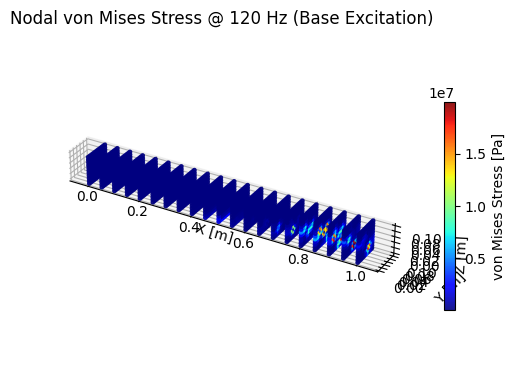

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -----------------------
# 데이터 로드
# -----------------------
nodes = pd.read_csv("nodes.csv")
stress = pd.read_csv("nodal_stress_120Hz.csv")

df = nodes.merge(stress, on=['x','y','z'])

x = df["x"].values
y = df["y"].values
z = df["z"].values

# -----------------------
# von Mises stress 계산
# -----------------------
sx = df["sigma_xx"].values
sy = df["sigma_yy"].values
sz = df["sigma_zz"].values
txy = df["tau_xy"].values
tyz = df["tau_yz"].values
tzx = df["tau_zx"].values

von_mises = np.sqrt(
    0.5 * (
        (sx - sy)**2 +
        (sy - sz)**2 +
        (sz - sx)**2
    )
    + 3.0 * (txy**2 + tyz**2 + tzx**2)
)

# -----------------------
# 3D Scatter Plot
# -----------------------
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    x, y, z,
    c=von_mises,
    cmap="jet",
    s=6,
    alpha=0.9
)

# -----------------------
# 축 비율 현실적으로 맞추기
# -----------------------
ax.set_box_aspect([
    np.ptp(x),
    np.ptp(y),
    np.ptp(z)
])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title("Nodal von Mises Stress @ 120 Hz (Base Excitation)")

cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("von Mises Stress [Pa]")

plt.tight_layout()
plt.show()


Number of converged eigenpairs 119
Mode 0: 0.004442786445924462 Hz
Mode 1: 0.004442786445964973 Hz
Mode 2: 0.004442786446167529 Hz
Mode 3: 0.004504617730278845 Hz
Mode 4: 0.004504617730498598 Hz
Mode 5: 0.004504617730498598 Hz
Mode 6: 0.004607695987286142 Hz
Mode 7: 0.004607695987344735 Hz
Mode 8: 0.00460769598750098 Hz
Mode 9: 0.0047513807755070825 Hz
Mode 10: 0.004751380775544962 Hz
Mode 11: 0.004751380775563902 Hz
Mode 12: 0.004933182509417514 Hz
Mode 13: 0.004933182509545208 Hz
Mode 14: 0.00493318250956345 Hz
Mode 15: 0.005146599445555476 Hz
Mode 16: 0.005146599445555476 Hz
Mode 17: 0.005146599445642904 Hz
Mode 18: 0.005377545452584125 Hz
Mode 19: 0.005377545452584125 Hz
Mode 20: 0.0053775454526343285 Hz
Mode 21: 0.005599292720097552 Hz
Mode 22: 0.005599292720113624 Hz
Mode 23: 0.005599292720210055 Hz
Mode 24: 0.005768501391448503 Hz
Mode 25: 0.005768501391495305 Hz
Mode 26: 0.005768501391588908 Hz
Mode 27: 0.006783164379603727 Hz
Mode 28: 0.006783164379696595 Hz
Mode 29: 0.0067831

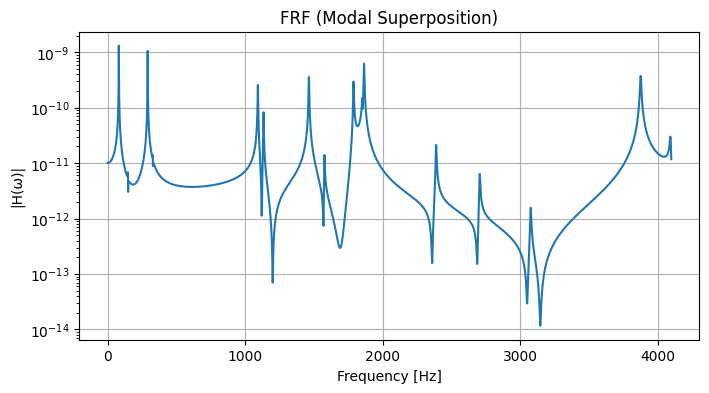

saved: nodal_stress_120Hz.csv
saved: nodes.csv
saved: cells.csv


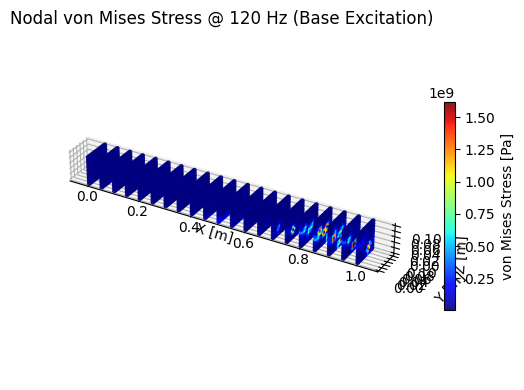

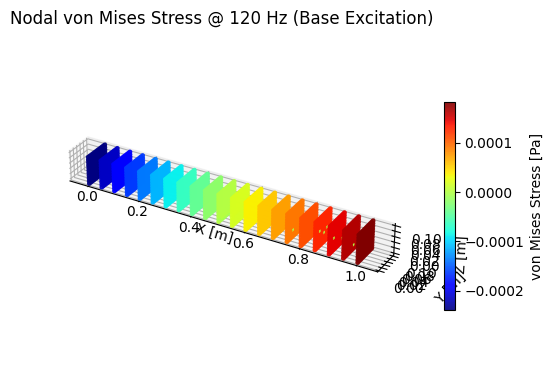

In [72]:
# -------------------------
# Geometry (3D block)
# -------------------------
Lx, Ly, Lz = 1.0, 0.1, 0.1
nx, ny, nz = 20, 10,10

domain = mesh.create_box(
    MPI.COMM_WORLD,
    np.array([[0.0, 0.0, 0.0],
             [Lx,  Ly,  Lz]]),
    [nx, ny, nz],
    cell_type=mesh.CellType.tetrahedron
)
# -------------------------
# Function space (3D displacement)
# -------------------------
Ve = VectorElement("Lagrange", domain.ufl_cell(), 1)
V = fem.FunctionSpace(domain, Ve)

u = TrialFunction(V)
v = TestFunction(V)

xm0, xm1 = 0.5, 0.55
ym0, ym1 = 0.01, 0.05
zm0, zm1 = 0, 0.01

m_add = 100.0  # kg (총 추가 질량)
dofs_mass = fem.locate_dofs_geometrical(V, in_mass_block)

if len(dofs_mass) == 0:
    raise RuntimeError("Mass block DOFs not found")

ndofs = len(dofs_mass)
m_per_dof = m_add / ndofs

for dof in dofs_mass:
    M.setValue(dof, dof, m_per_dof, addv=True)

M.assemble()

# Create and configure eigenvalue solver
N_eig = 90
eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
eigensolver.setDimensions(N_eig)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
st = SLEPc.ST().create(MPI.COMM_WORLD)
st.setType(SLEPc.ST.Type.SINVERT)
st.setShift(50)
st.setFromOptions()
eigensolver.setST(st)
eigensolver.setOperators(K, M)
eigensolver.setFromOptions()

# Compute eigenvalue-eigenvector pairs
eigensolver.solve()
evs = eigensolver.getConverged()
vr, vi = K.getVecs()
u_output = Function(V)
u_output.name = "Eigenvector"
print( "Number of converged eigenpairs %d" % evs )
if evs > 0:
    with XDMFFile(MPI.COMM_WORLD, "eigenvectors.xdmf", "w") as xdmf:
        xdmf.write_mesh(domain)
        for i in range (min(N_eig, evs)):
            l = eigensolver.getEigenpair(i, vr, vi)
            freq = np.sqrt(l.real)/2/np.pi
            print(f"Mode {i}: {freq} Hz")
            u_output.x.array[:] = vr
            xdmf.write_function(u_output, i)


x_force = np.array([0.5, 0.05, 0.05])   # 하중 위치
x_resp  = np.array([1, 0.05, 0.1])   # 응답 위치


coords = V.tabulate_dof_coordinates().reshape((-1, 3))

def find_nearest_dof(point):
    return np.argmin(np.linalg.norm(coords - point, axis=1))

dof_f = find_nearest_dof(x_force)
dof_r = find_nearest_dof(x_resp)

print("force dof:", dof_f)
print("resp dof :", dof_r)

Phi_f = []
Phi_r = []
modes = []     # ← 이게 modes
freqs = []     # 고유진동수도 같이 저장

for i in range(evs):
    l = eigensolver.getEigenpair(i, vr, vi)

    # 고유치 → 주파수
    if l.real <= 0:
        continue

    freq = np.sqrt(l.real) / (2*np.pi)

    # 저주파(강체모드) 컷
    if freq < 5.0:
        continue

    # PETSc Vec → dolfinx Function
    mode = Function(V)
    mode.x.array[:] = vr.array[:]   # ⭐ 핵심
    mode.name = f"mode_{i}"

    modes.append(mode)
    freqs.append(freq)

    print(f"Mode {i}: {freq:.2f} Hz")

omega_r = 2*np.pi*np.array(freqs)   # rad/s
for mode in modes:
    u = mode.x.array.reshape((-1, 3))
    Phi_f.append(u[dof_f, 2])   # 예: z방향
    Phi_r.append(u[dof_r, 2])

Phi_f = np.array(Phi_f)
Phi_r = np.array(Phi_r)

fmin, fmax = 0.0, 4096.0
npts = 4096
freq = np.linspace(fmin, fmax, npts)
omega = 2*np.pi*freq

zeta = 0.001   # 1% modal damping

H = np.zeros_like(omega, dtype=complex)

for r in range(len(omega_r)):
    num = Phi_r[r] * Phi_f[r]
    den = (omega_r[r]**2 - omega**2
           + 2j*zeta*omega_r[r]*omega)
    H += num / den


import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.semilogy(freq, np.abs(H))
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(ω)|")
plt.title("FRF (Modal Superposition)")
plt.grid(True)
plt.show()


import numpy as np
from petsc4py import PETSc
from dolfinx import fem
import ufl

freq = 120.0
omega = 2*np.pi*freq
a_base = 100.0       # m/s^2
zeta = 0.01

ndofs = M.getSize()[0]
bs = V.dofmap.index_map_bs

# ---- 베이스 영향 벡터 b (z방향) ----
b = PETSc.Vec().createMPI(ndofs, comm=M.comm)
b.set(0.0)

clamp_set = set(map(int, dofs_clamp))
r0, r1 = b.getOwnershipRange()
for dof in range(r0, r1):
    if (dof % bs) == 2 and (dof not in clamp_set):
        b.setValue(dof, 1.0)

b.assemblyBegin(); b.assemblyEnd()

Mb = M.createVecRight()
M.mult(b, Mb)

# ---- 모달 중첩 ----
u_resp = np.zeros(ndofs, dtype=np.complex128)

for r, mode in enumerate(modes):
    phi = PETSc.Vec().createWithArray(mode.x.array, comm=M.comm)
    Fr = - phi.dot(Mb) * a_base
    den = (omega_r[r]**2 - omega**2) + 2j*zeta*omega_r[r]*omega
    u_resp += (mode.x.array * Fr) / den

# clamp DOF는 상대변위 0
u_resp[np.array(dofs_clamp, dtype=np.int32)] = 0.0
u_real = fem.Function(V)
u_real.name = "u_real_120Hz"
u_real.x.array[:] = np.real(u_resp)
E = 210e9
nu = 0.3

mu = fem.Constant(domain, E / (2*(1+nu)))
lmbda = fem.Constant(domain, E*nu / ((1+nu)*(1-2*nu)))

def eps(u):
    return ufl.sym(ufl.grad(u))

def sigma(u):
    return lmbda * ufl.nabla_div(u) * ufl.Identity(3) + 2*mu*eps(u)


We = ufl.TensorElement("DG", domain.ufl_cell(), degree=0, shape=(3, 3))
W = fem.FunctionSpace(domain, We)
# W = fem.FunctionSpace(domain, ("DG", 0, (3,3)))   # cell-wise stress
stress_cell = fem.Function(W)
stress_expr = fem.Expression(sigma(u_real), W.element.interpolation_points())
stress_cell.interpolate(stress_expr)
Wn = fem.FunctionSpace(
    domain,
    ufl.TensorElement("Lagrange", domain.ufl_cell(), 1, shape=(3,3))
)

stress_node = fem.Function(Wn)
stress_node.name = "stress_120Hz"

w = ufl.TrialFunction(Wn)
v = ufl.TestFunction(Wn)

a_proj = ufl.inner(w, v) * ufl.dx
L_proj = ufl.inner(stress_cell, v) * ufl.dx

problem = fem.petsc.LinearProblem(
    a_proj, L_proj,
    u=stress_node,
    petsc_options={"ksp_type": "cg", "pc_type": "jacobi"}
)
problem.solve()
S = stress_node.x.array.reshape((-1, 9))

sig_xx = S[:,0]
sig_yy = S[:,4]
sig_zz = S[:,8]

tau_xy = S[:,1]
tau_yz = S[:,5]
tau_zx = S[:,6]
coords = domain.geometry.x

import pandas as pd
coords_nodes = domain.geometry.x
u_vec = u_real.x.array.reshape((-1, 3))  # NOTE: P1 vector면 "node 수"와 맞는 경우가 많지만, 안전하게는 아래 3.2를 권장

df_disp = pd.DataFrame({
    "node_id": np.arange(coords_nodes.shape[0]),
    "ux": u_vec[:,0],
    "uy": u_vec[:,1],
    "uz": u_vec[:,2],
})
df_disp.to_csv("nodal_disp_120Hz.csv", index=False)

df = pd.DataFrame({
    "node_id": np.arange(coords_nodes.shape[0]),
    "x": coords[:,0],
    "y": coords[:,1],
    "z": coords[:,2],
    "sigma_xx": sig_xx,
    "sigma_yy": sig_yy,
    "sigma_zz": sig_zz,
    "tau_xy": tau_xy,
    "tau_yz": tau_yz,
    "tau_zx": tau_zx
})

df.to_csv("nodal_stress_120Hz.csv", index=False)
print("saved: nodal_stress_120Hz.csv")
import pandas as pd

coords = domain.geometry.x

df_nodes = pd.DataFrame({
    "node_id": range(len(coords)),
    "x": coords[:,0],
    "y": coords[:,1],
    "z": coords[:,2]
})

df_nodes.to_csv("nodes.csv", index=False)
print("saved: nodes.csv")
tdim = domain.topology.dim
domain.topology.create_connectivity(tdim, 0)
conn = domain.topology.connectivity(tdim, 0)

rows = []
for cell_id in range(conn.num_nodes):
    nodes = conn.links(cell_id)
    row = {"cell_id": cell_id}
    for i, n in enumerate(nodes):
        row[f"node_{i}"] = int(n)
    rows.append(row)

df_cells = pd.DataFrame(rows)
df_cells.to_csv("cells.csv", index=False)
print("saved: cells.csv")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -----------------------
# 데이터 로드
# -----------------------
nodes = pd.read_csv("nodes.csv")
stress = pd.read_csv("nodal_stress_120Hz.csv")

df = nodes.merge(stress, on=['x','y','z'])

x = df["x"].values
y = df["y"].values
z = df["z"].values

# -----------------------
# von Mises stress 계산
# -----------------------
sx = df["sigma_xx"].values
sy = df["sigma_yy"].values
sz = df["sigma_zz"].values
txy = df["tau_xy"].values
tyz = df["tau_yz"].values
tzx = df["tau_zx"].values

von_mises = np.sqrt(
    0.5 * (
        (sx - sy)**2 +
        (sy - sz)**2 +
        (sz - sx)**2
    )
    + 3.0 * (txy**2 + tyz**2 + tzx**2)
)

# -----------------------
# 3D Scatter Plot
# -----------------------
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    x, y, z,
    c=von_mises,
    cmap="jet",
    s=6,
    alpha=0.9
)

# -----------------------
# 축 비율 현실적으로 맞추기
# -----------------------
ax.set_box_aspect([
    np.ptp(x),
    np.ptp(y),
    np.ptp(z)
])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title("Nodal von Mises Stress @ 120 Hz (Base Excitation)")

cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("von Mises Stress [Pa]")

plt.tight_layout()
plt.show()
# -----------------------
# 3D Scatter Plot
# -----------------------
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    x, y, z,
    c=u_vec[:,2],
    cmap="jet",
    s=6,
    alpha=0.9
)

# -----------------------
# 축 비율 현실적으로 맞추기
# -----------------------
ax.set_box_aspect([
    np.ptp(x),
    np.ptp(y),
    np.ptp(z)
])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.set_title("Nodal von Mises Stress @ 120 Hz (Base Excitation)")

cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("von Mises Stress [Pa]")

plt.tight_layout()
plt.show()